In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator

import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [2]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 
survival_data_100h = training_data_imputed_df[training_data_imputed_df['survival_time'] < 36]

In [3]:
survival_data_100h.shape

(85546, 170)

In [4]:
train_df, val_df = train_test_split(survival_data_100h, test_size=0.2, random_state=1)

In [64]:
X_train = train_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_time = train_df['survival_time'].clip(lower=0)
y_event = train_df['cdiff_30d_flag'].astype(bool)

Text(0.5, 0, 'time $t$ (days)')

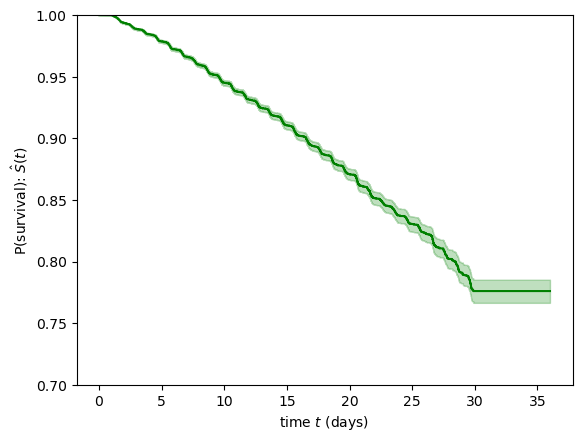

In [66]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    y_event, y_time, conf_type="log-log"
)
plt.step(time, survival_prob, color = "green")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post", color = "green")
plt.ylim(0.7, 1)
plt.ylabel(r"P(survival): $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")

---

In [74]:
train_surv = train_df[train_df['survival_time'] > 0]

In [105]:
X_train_surv = train_surv.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_event_time = train_surv[['cdiff_30d_flag', 'survival_time']]
# y_event_time['cdiff_30d_flag'] = y_event_time['cdiff_30d_flag'].astype(bool)

In [106]:
y_event_time['cdiff_30d_flag'].value_counts()

cdiff_30d_flag
0.0    63951
1.0     4367
Name: count, dtype: int64

In [107]:
y_array_event_time = np.array(list(zip(y_event_time['cdiff_30d_flag'], y_event_time['survival_time'])), 
                           dtype=[('field1', bool), ('field2', float)])

print(y_array_event_time)
print(y_array_event_time.shape)
print(X_train_surv.shape)

[(False,  8.83263889) (False,  7.23958333) (False, 22.67708333) ...
 (False,  6.82083333) ( True,  9.62152778) (False,  6.62361111)]
(68318,)
(68318, 166)


In [100]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train_surv, y_array_event_time)

/project/bios26406/conda/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.13289e-23): result may not be accurate.
  delta = solve(
/project/bios26406/conda/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/project/bios26406/conda/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/project/bios26406/conda/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:470: RuntimeWarning: invalid value encountered in scalar divide
  res = np.abs(1 - (loss_new / loss))
/project/bios26406/conda/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:194: RuntimeWarning: overflow encountered in exp
  exp_xw = np.exp(offset + np.dot(x, w))
/project/bios26406/conda/ml4h/lib/python3.13/site-packages/sksurv/linear_model/coxph.py:228: RuntimeWarn

ValueError: LAPACK reported an illegal value in 5-th argument.

In [29]:
# Evaluate on test set
cox_pred = cox_pipe.predict(X_test)
cox_cindex = concordance_index_censored(
    y_event, y_time, cox_pred)[0]
print(f"Cox model concordance index: {cox_cindex:.4f}")

NameError: name 'X_test' is not defined